This notebook implements CNN Transfer Learning to classify skin cancer types. 

Transfer Learning is a powerful way to leverage the performance of large pre-trained CNN models.  
With Transfer Learning the final dense Layers of the pre-trained CNNs used for image classification  
are replaced by (a) new dense layer(s) where the new final layer implements a Softmax activation over  
the new classes to predict. This way the extremely strong feature extractors of the pre-trained CNNs  
can be used to predict the new classes. General consensus exists that image features used to classify  
cars, airplanes, bicycles, etc. are also useful to e.g. classify between dog breeds.

Training the CNN with the new dense layers should be executed in 2 phases:
* Phase 1: Only train the new dense layers. This way the output of the CNN convolutions remains stable  
to allows the dense layers learn to classify the extracted features to classes. The original trained  
CNN layers will remain “frozen”.
* Phase 2: In this phase one additionally “fine-tunes” either the full CNN or selected layers only  
to further increase predictive accuracy of the network. A lower learning-rate is used to prevent too  
drastic changes to the feature extractors.

If the full CNN would be trained immediately, i.e. skipping phase 1, the completely untrained dense  
layers would initially create close-to-random predictions leading to a high loss. This loss would  
then be back-propagated through the whole CNN and likely “break” the already well-trained feature  detectors.


**Additional notes:**
1. Data Augmentation is provided in code, but not used here (resulted in weaker training progress)
2. Class-weight code included, but not used (resulted in weaker training progress)
3. The highly imbalanced dataset is not handled, code is included however.

Few useful links:

https://www.kaggle.com/adarshbiradar/xception-xgboost-94-accuracy
https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
https://www.kaggle.com/zhyaqi/skin-lesion-inceptionv3
https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app
https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing#Make-an-MNIST-Like-Dataset
https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch

https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

import itertools

import cv2
from PIL import Image

In [2]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Load Metadata

In [3]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


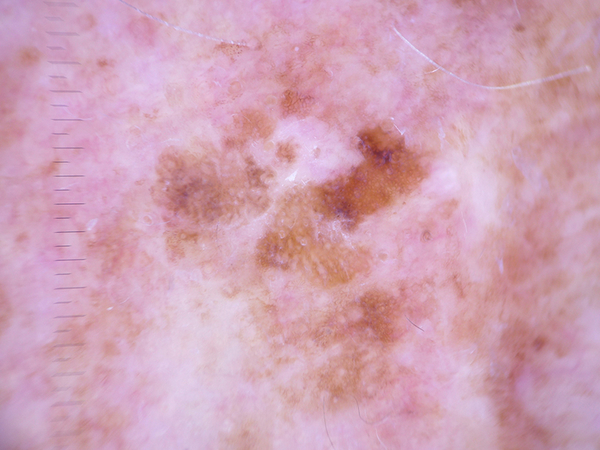

In [4]:
Image.open('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg')

Now lets plot the counts of the differenct classes to classify.

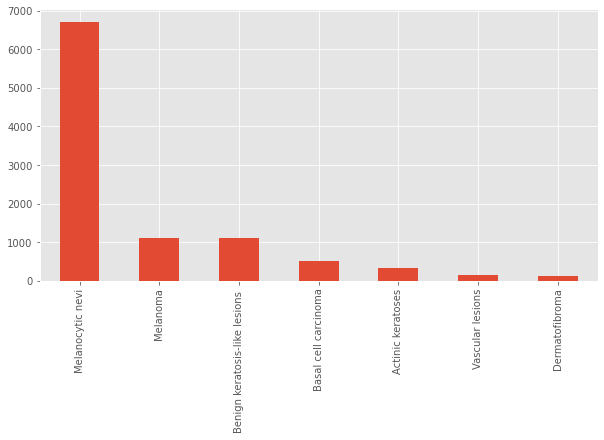

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [6]:
data['cell_type'].value_counts() < 1000


Melanocytic nevi                  False
Melanoma                          False
Benign keratosis-like lesions     False
Basal cell carcinoma               True
Actinic keratoses                  True
Vascular lesions                   True
Dermatofibroma                     True
Name: cell_type, dtype: bool

# Load images

As seen above, the dataset is highly imbalanced. So let's resample/upsample each class to 7000 instances.
The code below returns a balanced dataset, in which each class has 7000 instances. Of course this leads to heavily redundant data in categories with originally very few instances.

In [7]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=7000,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

Images will be rescaled to (128,128,3) and standardized (division by 255)

In [8]:
def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [9]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [02:10<00:00, 76.71it/s]


(10015, 128, 128, 3)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9514, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

In [11]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        # Fine-tune the full CNN + FC
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

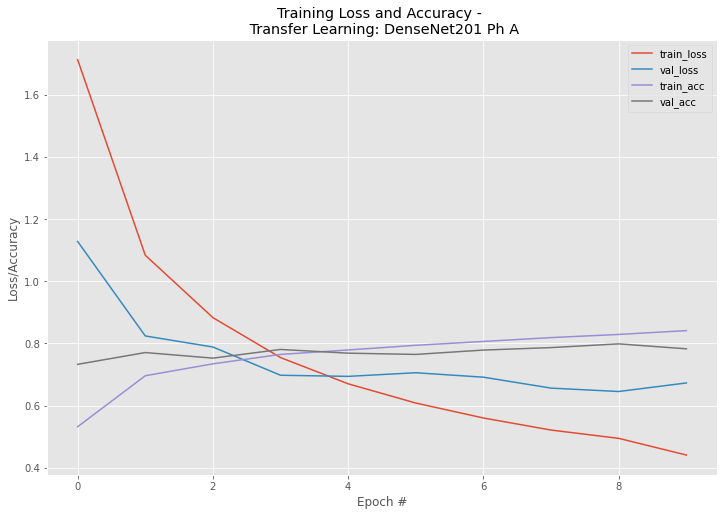


Phase B  - Fine Tune all Layers 

Epoch 1/10
74/74 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.6684
Epoch 00001: val_loss improved from inf to 0.84549, saving model to DenseNet201_ph2_weights.hdf5
74/74 [==============================] - 37s 496ms/step - loss: 1.2607 - accuracy: 0.6684 - val_loss: 0.8455 - val_accuracy: 0.7465
Epoch 2/10
74/74 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.7436
Epoch 00002: val_loss did not improve from 0.84549
74/74 [==============================] - 29s 390ms/step - loss: 0.8557 - accuracy: 0.7436 - val_loss: 1.0491 - val_accuracy: 0.7385
Epoch 3/10
74/74 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.7825
Epoch 00003: val_loss did not improve from 0.84549
74/74 [==============================] - 29s 389ms/step - loss: 0.6581 - accuracy: 0.7825 - val_loss: 1.0544 - val_accuracy: 0.7206
Epoch 4/10
74/74 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0

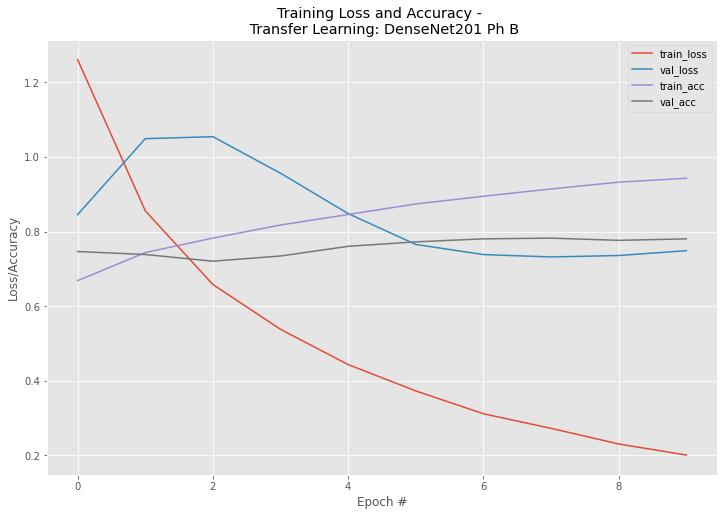

In [12]:
NET = 'DenseNet201'
HIDDEN_LAYERS = [512, 128]
#HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 10

model = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

In [13]:
model.predict()


Predicting test set classes.
Test set score: [0.10702815651893616, 0.9820269346237183]
Done


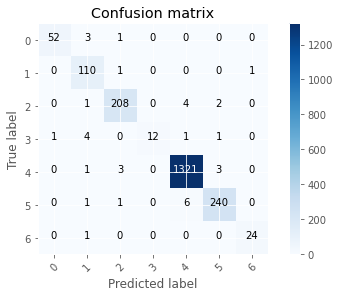

In [14]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [17]:
model.model.save('tuned_model') 

In [18]:
!ls

DenseNet201_ph1_weights.hdf5  __notebook_source__.ipynb
DenseNet201_ph2_weights.hdf5  tuned_model
